In [1]:
import numpy as np
import matplotlib.pyplot as plt
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.agent import AgentBase
from amalearn.reward import RewardBase

# Rewards

In [2]:
class GaussianReward(RewardBase):
    def __init__(self, mean, std):
        super(GaussianReward, self).__init__()
        self.mean = mean
        self.std = std

    def get_reward(self):
        return np.random.normal(loc=self.mean, scale=self.std)

In [3]:
class BernoulliReward(RewardBase):
    def __init__(self, bandit_prob, reward, punishment):
        super(RewardBase, self).__init__()
        self.bandit_prob = bandit_prob
        self.reward = reward
        self.punishment = punishment

    def get_reward(self):
        r = np.random.binomial(1, self.bandit_prob)
        return self.reward if r == 1 else self.punishment

# Agents

In [4]:

class EpsilonGreedyAgent(AgentBase):
    def __init__(self, id, environment, epsilon, status, alpha, beta, lambdaa):
        super(EpsilonGreedyAgent, self).__init__(id, environment)
        self.epsilon = epsilon
        self.status = status
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa

    def select_action(self):
        available_actions = self.available_actions
        eps = self.epsilon

        best_action = np.argmax(self.q_values)
        random_action = np.random.choice(available_actions)

        prob_best_action = 1 - eps + (eps / available_actions)
        prob_random_action = eps / available_actions
        sum = prob_best_action + prob_random_action #normalize
        selected_action = np.random.choice([best_action, random_action], p=[prob_best_action/sum, prob_random_action/sum])
        return selected_action

    def update(self, action, r):
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        self.q_values[action] = self.rewards[action] / self.counts[action]
        if self.status == "adaptive":
            self.epsilon = self.epsilon/2

    def utility(self, r):
        if r>=0:
            return r**self.alpha
        else:
            return -self.lambdaa * abs(r)**self.beta

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update(action, r)
        self.environment.render()
        return obs, r, d, i

In [67]:
class UCBAgent(AgentBase):
    def __init__(self, id, environment, c, alpha, beta, lambdaa):
        super(UCBAgent, self).__init__(id, environment)
        self.c = c
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa

    def calculate_ucb(self, action):
        if self.counts[action] == 0:
            return np.inf
        else:
            return self.q_value[action] + self.c * np.sqrt((np.log(sum(self.counts))) / self.counts[action])

    def select_action(self):
        available_actions = np.arange(1, self.available_actions)
        ucb = [self.calculate_ucb(action) for action in available_actions]
        return np.argmax(ucb)

    def update(self, action, r):
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        self.q_values[action] = self.rewards[action] / self.counts[action]
    
    def utility(self, r):
        if r>=0:
            return r**self.alpha
        else:
            return -self.lambdaa * (abs(r)**self.beta)

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update(action, r)
        self.environment.render()
        return obs, r, d, i

# Run

In [6]:
def main_run(env, trials, rounds, status, epsilon, eps_status, alpha, beta, lambdaa):
    total_rewards = np.zeros((trials, rounds))
    for round in range(rounds):
        env.reset()
        
        if status == "EpsilonGreedyAgent":
            agent = EpsilonGreedyAgent(round, env, epsilon, eps_status, alpha, beta, lambdaa)
        if status == "UCBAgent":
            agent = UCBAgent(round, env, 1, alpha, beta, lambdaa)
            
        for trial in range(trials):
            agent.take_action()
            total_rewards[trial][round] = sum(agent.rewards)/(trial+1)
    mean_reward = np.mean(total_rewards, axis=1)
    return mean_reward

In [7]:
r1 = GaussianReward(10, 1)
r2 = GaussianReward(8, 2)
r3 = GaussianReward(9, 1)
r4 = BernoulliReward(0.5, 9, -9)

In [8]:
trials = 1000
rounds = 20

In [9]:
rewards = [r1, r2, r3, r4]
env = MutliArmedBanditEnvironment(rewards, 1000, '1')

In [10]:
eps_mean_reward = main_run(env, trials, rounds, "EpsilonGreedyAgent", 0.8, "const", 1, 1 ,1)

In [11]:
adaptive_eps_mean_reward = main_run(env, trials, rounds, "EpsilonGreedyAgent", 0.9, "adaptive", 1, 1 ,1)

In [12]:
ucb_mean_reward = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1 ,1)

# plot

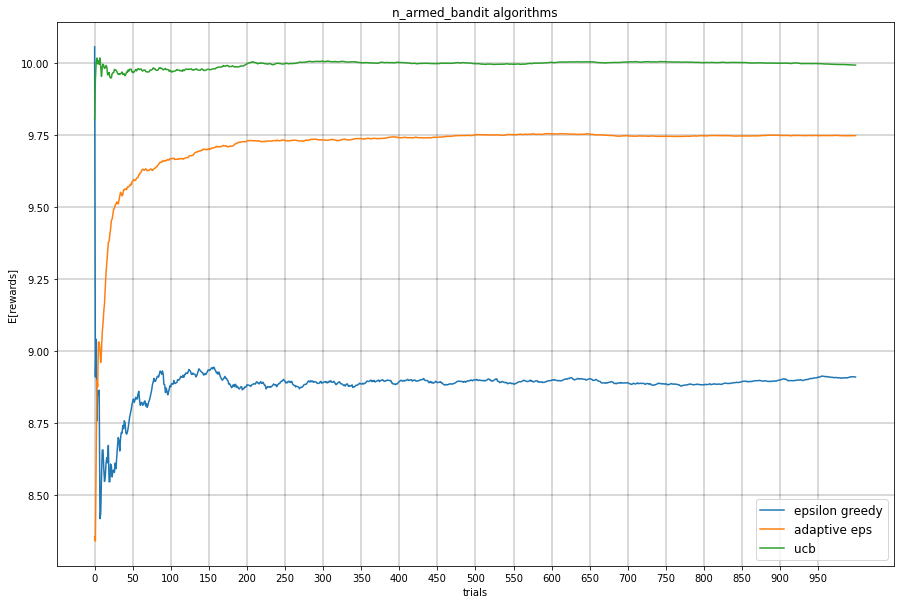

In [13]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(eps_mean_reward, label="epsilon greedy")
plt.plot(adaptive_eps_mean_reward, label="adaptive eps")
plt.plot(ucb_mean_reward, label="ucb")
plt.title("n_armed_bandit algorithms")

plt.xlabel("trials", fontsize = 10)
plt.ylabel("E[rewards]", fontsize = 10)
plt.legend(loc='best',fontsize = 12)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

# change $\alpha$

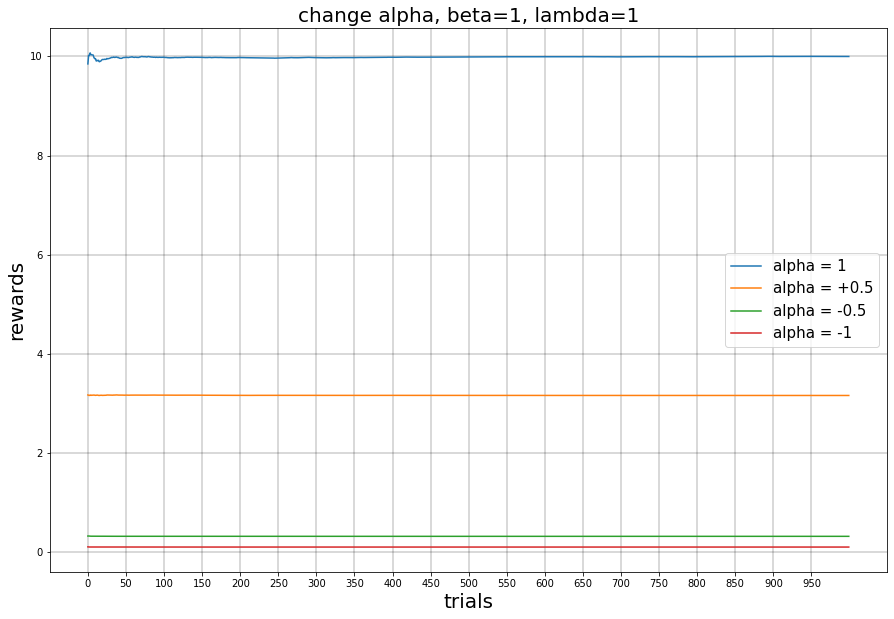

In [47]:
ucb_mean_reward_alpha1 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1, 1)
ucb_mean_reward_alpha2 = main_run(env, trials, rounds, "UCBAgent", None, None, -0.5, 1 ,1)
ucb_mean_reward_alpha3 = main_run(env, trials, rounds, "UCBAgent", None, None, +0.5, 1 ,1)
ucb_mean_reward_alpha4 = main_run(env, trials, rounds, "UCBAgent", None, None, -1, 1 ,1)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(ucb_mean_reward_alpha1, label="alpha = 1")
plt.plot(ucb_mean_reward_alpha3, label="alpha = +0.5")
plt.plot(ucb_mean_reward_alpha2, label="alpha = -0.5")
plt.plot(ucb_mean_reward_alpha4, label="alpha = -1")

plt.title("change alpha, beta=1, lambda=1", fontsize = 20)
plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

# change $\beta$

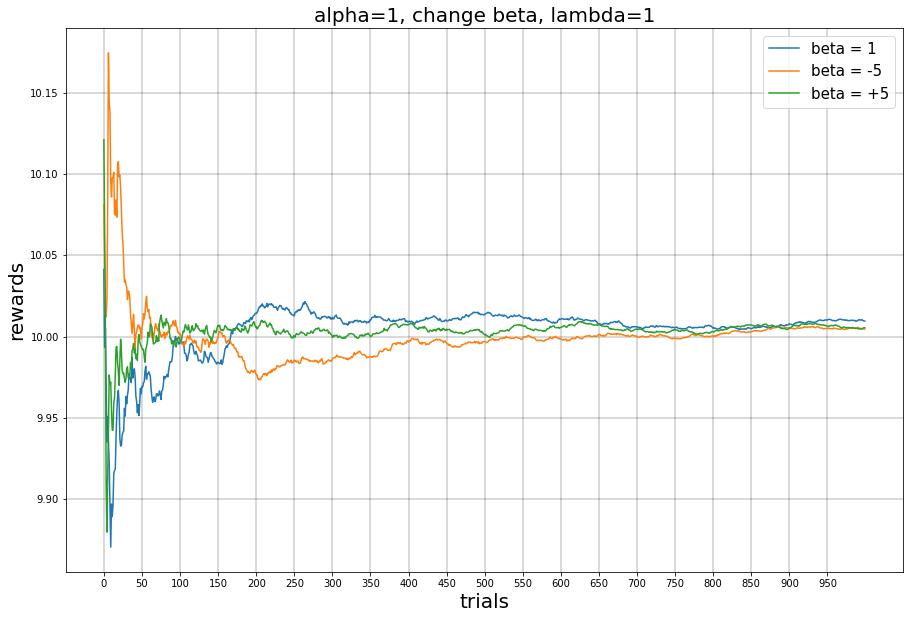

In [52]:
ucb_mean_reward_beta1 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1, 1)
ucb_mean_reward_beta2 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, -5 ,1)
ucb_mean_reward_beta3 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, +5 ,1)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(ucb_mean_reward_beta1, label="beta = 1")
plt.plot(ucb_mean_reward_beta2, label="beta = -5")
plt.plot(ucb_mean_reward_beta3, label="beta = +5")

plt.title("alpha=1, change beta, lambda=1", fontsize = 20)
plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

# change $\lambda$

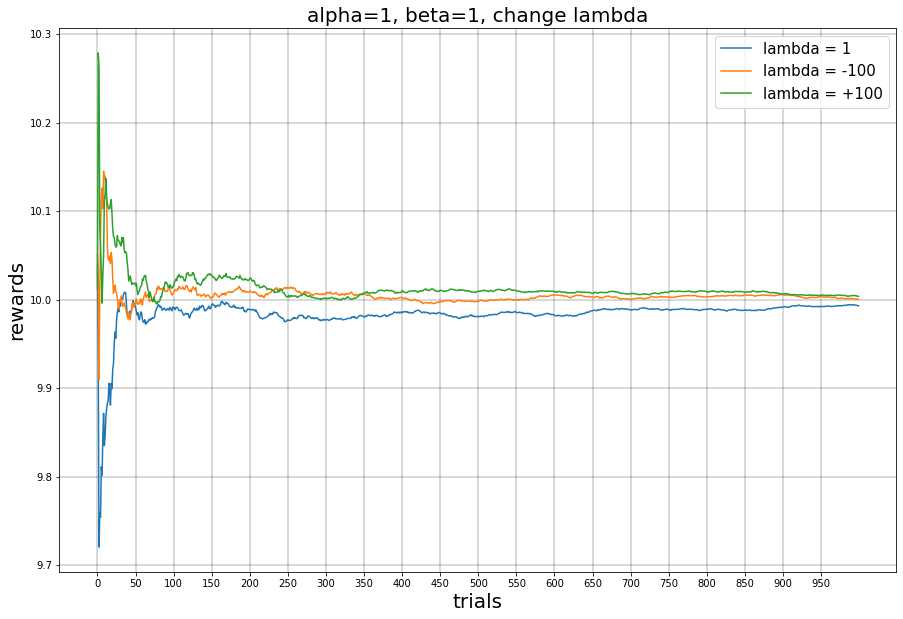

In [69]:
ucb_mean_reward_lambda1 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1, 1)
ucb_mean_reward_lambda2 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1, -100)
ucb_mean_reward_lambda3 = main_run(env, trials, rounds, "UCBAgent", None, None, 1, 1, +100)

fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(ucb_mean_reward_lambda1, label="lambda = 1")
plt.plot(ucb_mean_reward_lambda2, label="lambda = -100")
plt.plot(ucb_mean_reward_lambda3, label="lambda = +100")

plt.title("alpha=1, beta=1, change lambda", fontsize = 20)
plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

In [18]:

class GradientBandit(AgentBase):
    def __init__(self, id, environment, alpha, beta, lambdaa, learning_rate):
        super(GradientBandit, self).__init__(id, environment)
        
        self.H = np.zeros(self.environment.available_actions())
        self.R = 0
        
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa
        self.learning_rate = learning_rate
        
    def policy(self):
        return np.exp(self.H)/np.sum(np.exp(self.H))
    
    def select_action(self):
        return np.random.choice(self.available_actions, p = self.policy())

    def update(self, action, r):
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        policy = self.policy()
        for a in range(self.available_actions):
            if a == action:
                self.H[a] += self.learning_rate * (r-self.R) * (1-policy[a])
            else:
                self.H[a] -= self.learning_rate * (r-self.R) * (policy[a])
                
        self.R = np.sum(self.rewards)/np.sum(self.counts)

    def utility(self, r):
        if r>=0:
            return r**self.alpha
        else:
            return -self.lambdaa * abs(r)**self.beta

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        # print(obs, r, d, i)
        self.update(action, r)
        self.environment.render()
        return obs, r, d, i

In [19]:
total_rewards = np.zeros((trials, rounds))
for round in range(rounds):
    env.reset()
    agent = GradientBandit(1, env, 1, 1, 1, 1)

    for trial in range(trials):
        agent.take_action()
        total_rewards[trial][round] = sum(agent.rewards)/(trial+1)
mean_reward = np.mean(total_rewards, axis=1)

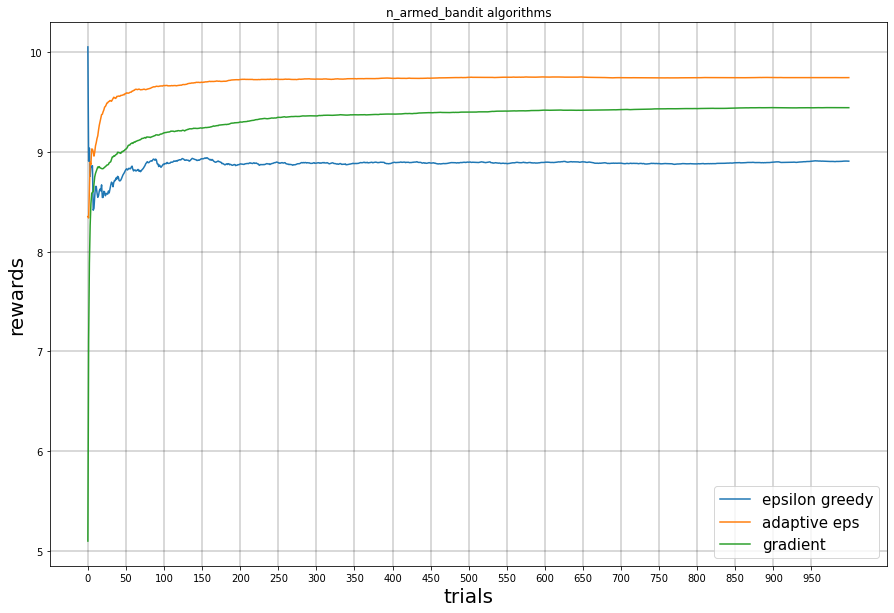

In [70]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(eps_mean_reward, label="epsilon greedy")
plt.plot(adaptive_eps_mean_reward, label="adaptive eps")
plt.plot(mean_reward, label="gradient")
plt.title("n_armed_bandit algorithms")

plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

In [1]:
import os
os.system('jupyter nbconvert --to html HW2_Q1_a.ipynb')

0